# Generalized Stacking Ensemble Learning

**Takes over from cat_boost_clean_1.ipynb**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [3]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True
            
    threshold = 6

    return sorted([t for t in intervals if t[1] - t[0] >= threshold], key=lambda t: t[1] - t[0], reverse=True)

In [4]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


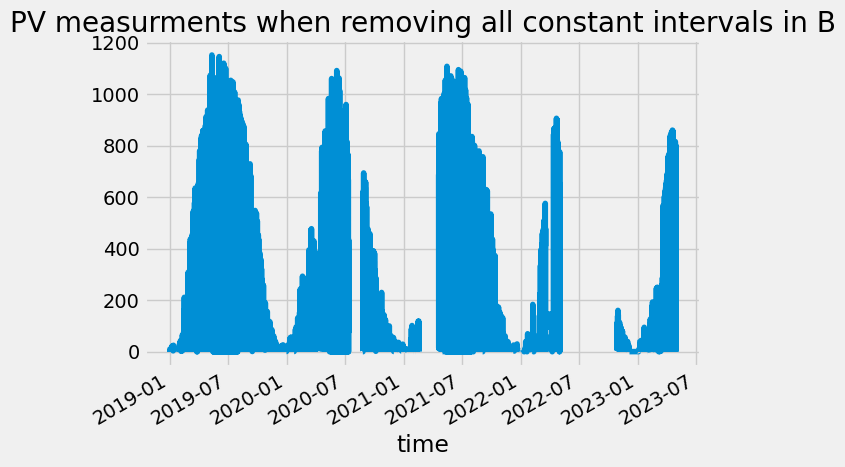

In [5]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [ ]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [ ]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [ ]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [ ]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'

y.shape
y.head()

,pv_measurement,location
time,,
2019-06-02 22:00:00,0.000000,A
2019-06-02 23:00:00,0.000000,A
2019-06-03 00:00:00,0.000000,A
2019-06-03 01:00:00,0.000000,A
2019-06-03 02:00:00,0.003377,A


Setting the index to **date_forecast** and resampling with median.

In [ ]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [ ]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

### Removing 'outlier' features as this gave us 0.1 better score on Kaggle

In [ ]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa']


for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [ ]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [ ]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

In [ ]:
df = pd.merge(y, X, left_on=[y.index, 'location'],
              right_on=[X.index, 'location'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,B,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,0.0,275.150009,...,-48.389500,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0
2019-01-01 00:00:00,NaN,C,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,1.0,275.000000,...,-48.426498,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0
2019-01-01 01:00:00,NaN,C,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,1.0,274.650009,...,-45.002501,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0
2019-01-01 01:00:00,NaN,B,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,0.0,274.849991,...,-44.971498,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0
2019-01-01 02:00:00,NaN,B,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,0.0,274.800003,...,-39.896000,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0


In [ ]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 23)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 23)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,month_sin,month_cos,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,B,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,0.0,275.150009,...,16823.399902,2.80,1.20,2.55,-0.0,0,0.5,0.866025,0.000000,1.000000
2019-01-01 00:00:00,NaN,C,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,1.0,275.000000,...,16512.299805,2.90,1.10,2.65,-0.0,0,0.5,0.866025,0.000000,1.000000
2019-01-01 01:00:00,NaN,C,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,1.0,274.650009,...,13277.399902,3.65,1.40,3.35,-0.0,0,0.5,0.866025,0.269797,0.962917
2019-01-01 01:00:00,NaN,B,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,0.0,274.849991,...,12777.449707,3.55,1.50,3.20,-0.0,0,0.5,0.866025,0.269797,0.962917
2019-01-01 02:00:00,NaN,B,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,0.0,274.800003,...,11142.549805,4.05,2.15,3.45,-0.0,0,0.5,0.866025,0.519584,0.854419


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [ ]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
    'location'
]

TARGET = 'pv_measurement'

In [ ]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [ ]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3             72
air_density_2m:kgm3                1824
clear_sky_energy_1h:J                72
clear_sky_rad:W                      72
dew_or_rime:idx                      72
dew_point_2m:K                       72
diffuse_rad:W                        72
diffuse_rad_1h:J                     72
direct_rad:W                         72
direct_rad_1h:J                      72
effective_cloud_cover:p              72
elevation:m                          72
fresh_snow_12h:cm                    72
fresh_snow_1h:cm                     72
fresh_snow_24h:cm                    72
fresh_snow_3h:cm                     72
fresh_snow_6h:cm                     72
is_day:idx                           72
is_in_shadow:idx                     72
msl_pressure:hPa                   1832
precip_5min:mm                       72
precip_type_5min:idx                 72
pressure_100m:hPa                    72
pressure_50m:hPa                     72
prob_rime:p                          72


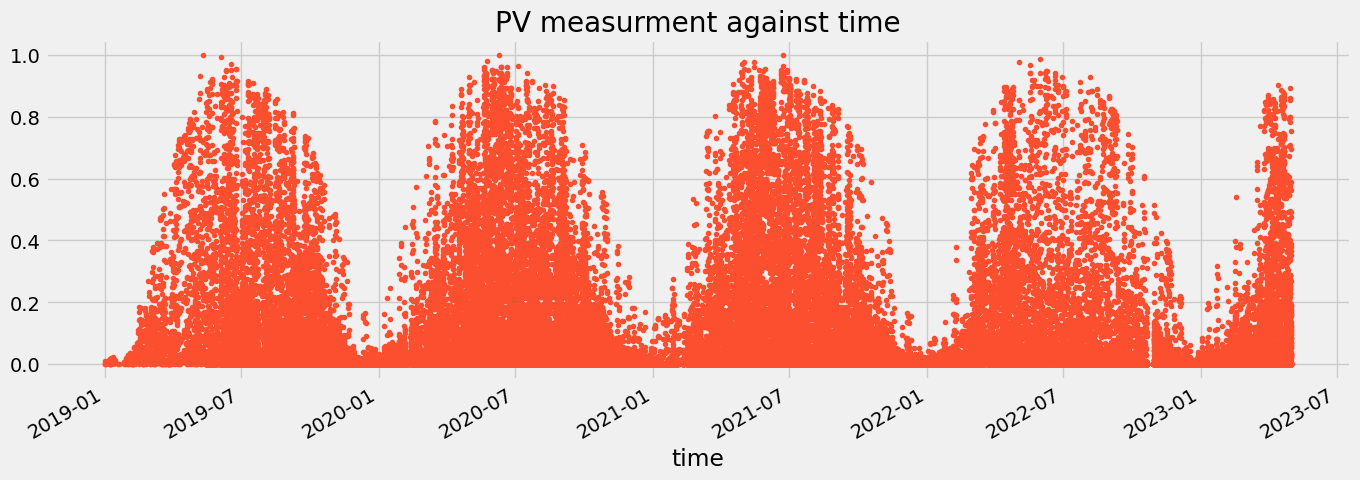

In [ ]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    x_test['location'] = location

    x_test['location'] = x_test['location'].astype('category')

    return x_test

In [ ]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [ ]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [ ]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [ ]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

In [ ]:
X_test_kaggle = X_test

### Disability Check

Check if the training data and the test data contains the same columns.

In [ ]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [ ]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [ ]:
X, y = df[FEATURES], df[TARGET]

In [ ]:
X['location'] = X['location'].astype('category')

/var/folders/s2/v6q39rgs1xs8ww30dn78jkb00000gn/T/ipykernel_23566/1794122678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['location'] = X['location'].astype('category')


# ---------------------Ensemble Learning---------------------

### 1. Prepare train/test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test_local, y_train, y_test_local = train_test_split(X, y, test_size=0.15, random_state=42, shuffle= False)

<function matplotlib.pyplot.show(close=None, block=None)>

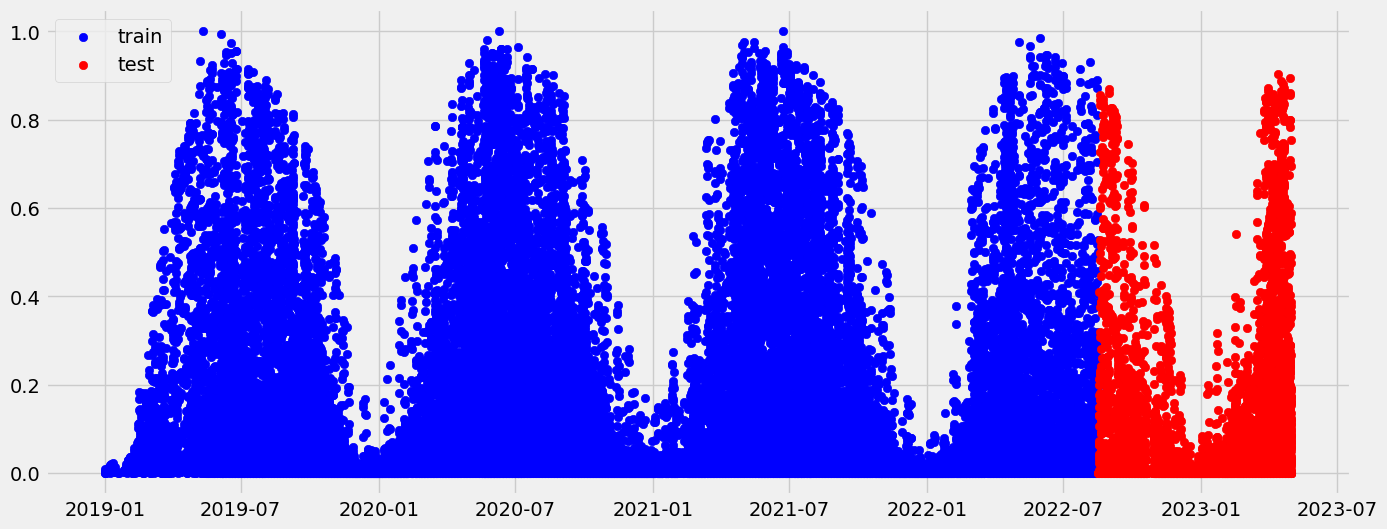

In [ ]:
plt.figure(figsize=(15,6))

plt.scatter(x=y_train.to_frame().index, y=y_train.to_frame()['pv_measurement'], color='blue', label='train')
plt.scatter(x=y_test_local.to_frame().index, y=y_test_local.to_frame()['pv_measurement'], color='red', label='test')

plt.legend()
plt.show

### 2. Select models to ensemble

In [ ]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

estimators =   [('CatBoost', CatBoostRegressor(cat_features=["location"])), 
                ('XGBoost', XGBRegressor(enable_categorical=True))]

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
final_estimator = GradientBoostingRegressor(n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=42)

In [ ]:
from sklearn.ensemble import StackingRegressor
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

In [ ]:
model.fit(X_train, y_train)

Learning rate set to 0.075441
0:	learn: 0.2024585	total: 86ms	remaining: 1m 25s
1:	learn: 0.1910203	total: 155ms	remaining: 1m 17s
2:	learn: 0.1806881	total: 210ms	remaining: 1m 9s
3:	learn: 0.1712508	total: 264ms	remaining: 1m 5s
4:	learn: 0.1624763	total: 301ms	remaining: 59.8s
5:	learn: 0.1546681	total: 349ms	remaining: 57.8s
6:	learn: 0.1474829	total: 407ms	remaining: 57.8s
7:	learn: 0.1411320	total: 465ms	remaining: 57.7s
8:	learn: 0.1352804	total: 535ms	remaining: 58.9s
9:	learn: 0.1299816	total: 591ms	remaining: 58.5s
10:	learn: 0.1250536	total: 639ms	remaining: 57.5s
11:	learn: 0.1208011	total: 698ms	remaining: 57.4s
12:	learn: 0.1168952	total: 766ms	remaining: 58.2s
13:	learn: 0.1134996	total: 815ms	remaining: 57.4s
14:	learn: 0.1105189	total: 925ms	remaining: 1m
15:	learn: 0.1077773	total: 956ms	remaining: 58.8s
16:	learn: 0.1052480	total: 1s	remaining: 57.9s
17:	learn: 0.1029686	total: 1.03s	remaining: 56.5s
18:	learn: 0.1009709	total: 1.07s	remaining: 55.5s
19:	learn: 0.099

/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:463: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:464: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marcusfuglestad/Desktop/NTN

Learning rate set to 0.072827
0:	learn: 0.2035399	total: 24.6ms	remaining: 24.6s
1:	learn: 0.1923605	total: 65.6ms	remaining: 32.7s
2:	learn: 0.1822308	total: 106ms	remaining: 35.1s
3:	learn: 0.1727589	total: 145ms	remaining: 36s
4:	learn: 0.1642865	total: 179ms	remaining: 35.6s
5:	learn: 0.1564748	total: 208ms	remaining: 34.5s
6:	learn: 0.1493467	total: 283ms	remaining: 40.1s
7:	learn: 0.1429456	total: 328ms	remaining: 40.6s
8:	learn: 0.1370318	total: 356ms	remaining: 39.2s
9:	learn: 0.1316895	total: 371ms	remaining: 36.8s
10:	learn: 0.1268612	total: 422ms	remaining: 38s
11:	learn: 0.1224898	total: 453ms	remaining: 37.3s
12:	learn: 0.1185138	total: 488ms	remaining: 37.1s
13:	learn: 0.1148294	total: 508ms	remaining: 35.8s
14:	learn: 0.1116181	total: 536ms	remaining: 35.2s
15:	learn: 0.1087298	total: 565ms	remaining: 34.7s
16:	learn: 0.1061132	total: 606ms	remaining: 35s
17:	learn: 0.1037399	total: 642ms	remaining: 35s
18:	learn: 0.1015374	total: 666ms	remaining: 34.4s
19:	learn: 0.0996

/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:463: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:464: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marcusfuglestad/Desktop/NTN

StackingRegressor(estimators=[('CatBoost',
                               <catboost.core.CatBoostRegressor object at 0x157e3dde0>),
                              ('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_poli...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=GradientBoostingRegressor(max_features=1,
                                                            min_samples_leaf=25,
                                                            n_estimators=25,
                                                            random_state=42,
                                                            subsample=0.5))

In [ ]:
pred_local = model.predict(X_test_local)

In [ ]:
from sklearn.metrics import mean_squared_error
test_score = mean_squared_error(y_test_local, pred_local)
print("Test Score:", test_score)

Test Score: 0.005160550811768296


In [ ]:
residuals = y_test_local - pred_local

In [ ]:
color_pal = sns.color_palette()

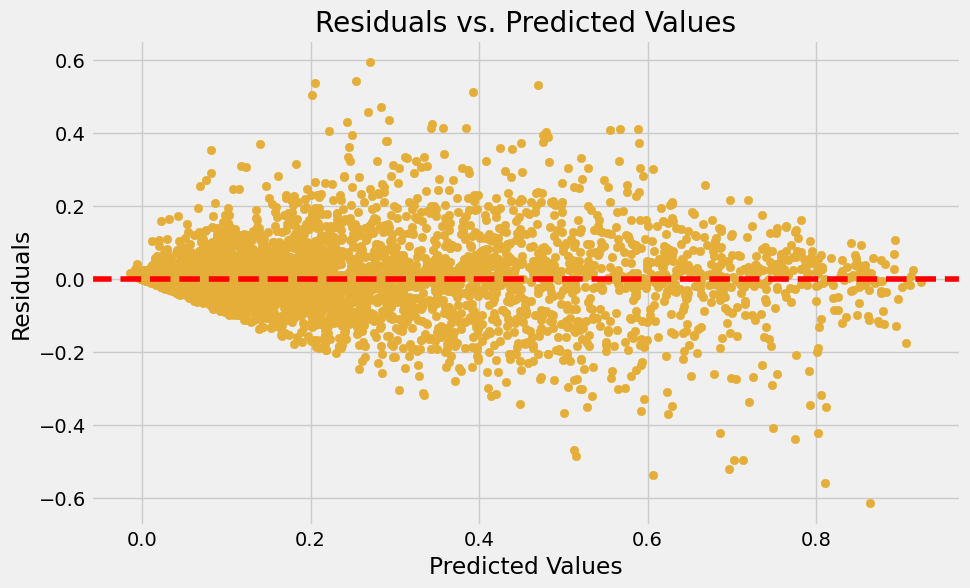

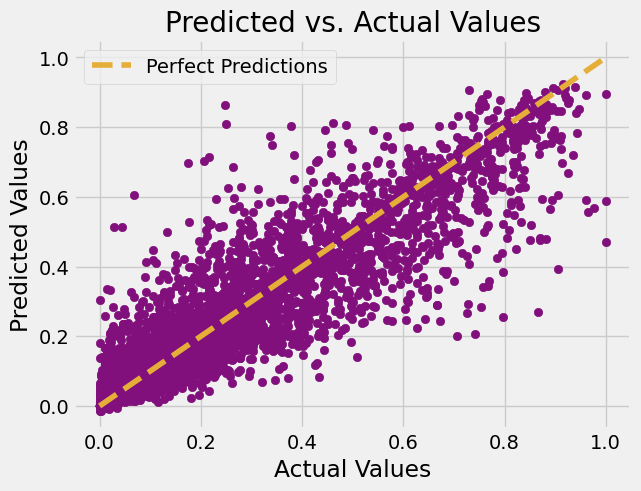

In [ ]:
# RESIDUALS
plt.figure(figsize=(10, 6))
plt.scatter(pred_local, residuals, color=color_pal[2])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# PRED vs. ACTUAL
plt.scatter(y_test_local, pred_local, color=color_pal[5])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.plot([min(y_test_local), max(y_test_local)], [min(y_test_local), max(y_test_local)], color=color_pal[2], linestyle='--', label='Perfect Predictions')
plt.legend()

# THE MAIN FIGURE TO WORRY ABOUT

### Residual = Actual - Pred

In [ ]:
print("The average residuals:")
print(np.mean(residuals))

The average residuals:
0.002375737876685339


In [ ]:
model.fit(X, y)

0:	learn: 0.1296519	total: 34.2ms	remaining: 34.2s
1:	learn: 0.1267576	total: 63.8ms	remaining: 31.8s
2:	learn: 0.1237888	total: 90.6ms	remaining: 30.1s
3:	learn: 0.1207813	total: 118ms	remaining: 29.5s
4:	learn: 0.1181852	total: 144ms	remaining: 28.7s
5:	learn: 0.1154286	total: 170ms	remaining: 28.2s
6:	learn: 0.1129686	total: 197ms	remaining: 28s
7:	learn: 0.1105418	total: 225ms	remaining: 27.9s
8:	learn: 0.1079691	total: 253ms	remaining: 27.9s
9:	learn: 0.1055132	total: 288ms	remaining: 28.5s
10:	learn: 0.1031288	total: 316ms	remaining: 28.4s
11:	learn: 0.1007046	total: 342ms	remaining: 28.2s
12:	learn: 0.0984847	total: 370ms	remaining: 28.1s
13:	learn: 0.0962928	total: 397ms	remaining: 28s
14:	learn: 0.0942081	total: 424ms	remaining: 27.9s
15:	learn: 0.0922803	total: 452ms	remaining: 27.8s
16:	learn: 0.0904319	total: 481ms	remaining: 27.8s
17:	learn: 0.0886481	total: 510ms	remaining: 27.8s
18:	learn: 0.0869759	total: 536ms	remaining: 27.7s
19:	learn: 0.0851363	total: 564ms	remainin

### Predict and make csv

In [ ]:
predictions = model.predict(X_test_kaggle)

In [ ]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,0.000010
1,0.000016
2,0.000057
3,0.005925
4,0.052958


In [ ]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [ ]:
n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))

In [ ]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [ ]:
predictions.head(10)

,prediction
0,0.056668
1,0.089932
2,0.327782
3,33.970749
4,303.632674
5,683.836568
6,1513.732007
7,2377.910927
8,2704.963731
9,2757.021508


In [ ]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [ ]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [ ]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

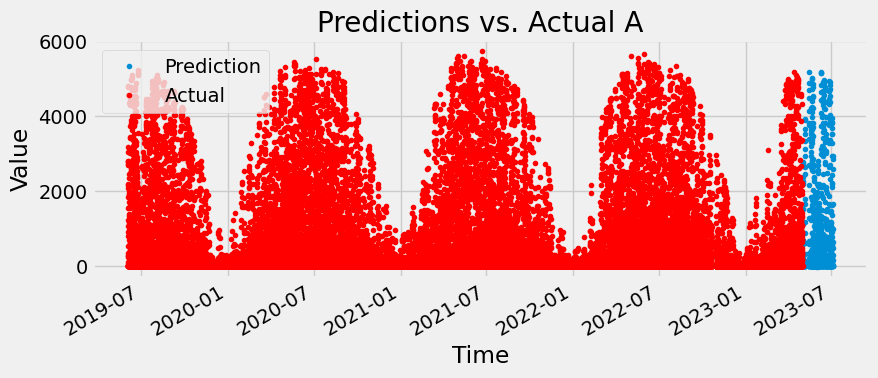

In [ ]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

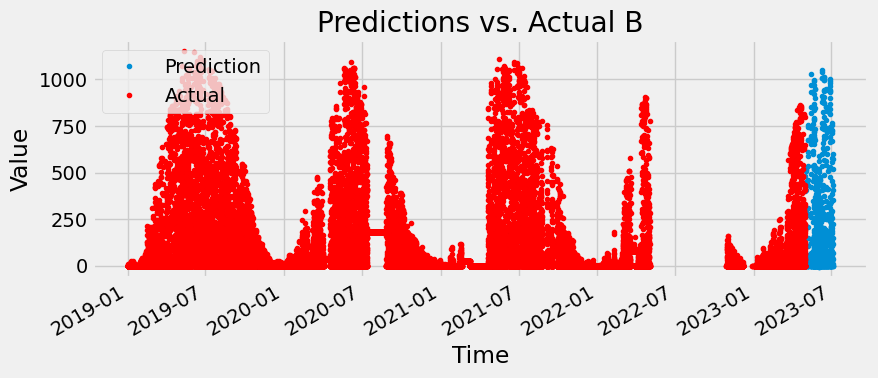

In [ ]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


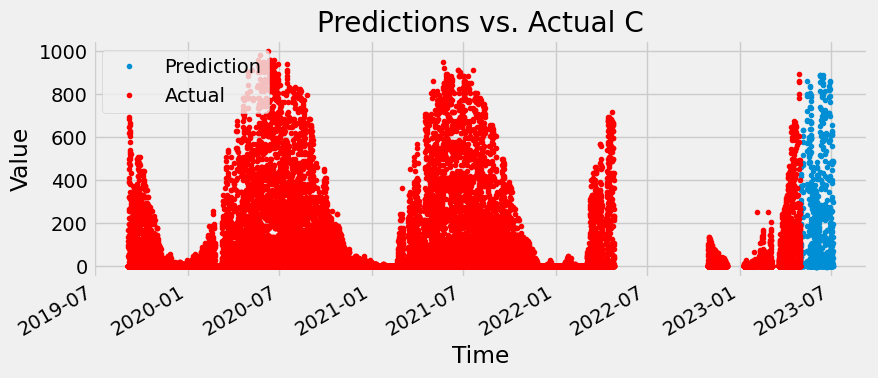

In [ ]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()